In [70]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns       
import pandas as pd                           # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from iminuit.cost import LeastSquares

In [71]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

# Problem 3

In [72]:
r = np.random
r.seed(42)

save_plots = False   
N_points = 10000      # Number of random points to be produced!

xmin = 0.0
xmax = 1.0
N_bins = 100

# Define f(x) = 2x, for x in [0,1]
def fx_2x(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N * 8.0125*x**3*np.sin(np.pi*x)

In [73]:
N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = 3.0      # Maximum value the function will take!
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < 8.0125*x_test**3*np.sin(np.pi*x_test)):
            break
            
    x_accepted[i] = x_test

In [74]:
# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)

# Error on integral
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

print(f"\nIntegral of f(x) = x, x in [0, 1] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the Accept/Reject method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# We normalized the function ahead of time, so we should hope to get a result consistent with unity!


Integral of f(x) = x, x in [0, 1] is: 	  0.9943 +- 0.0081
The efficiency of the Accept/Reject method used here is: 	 33.14% +/- 0.27%


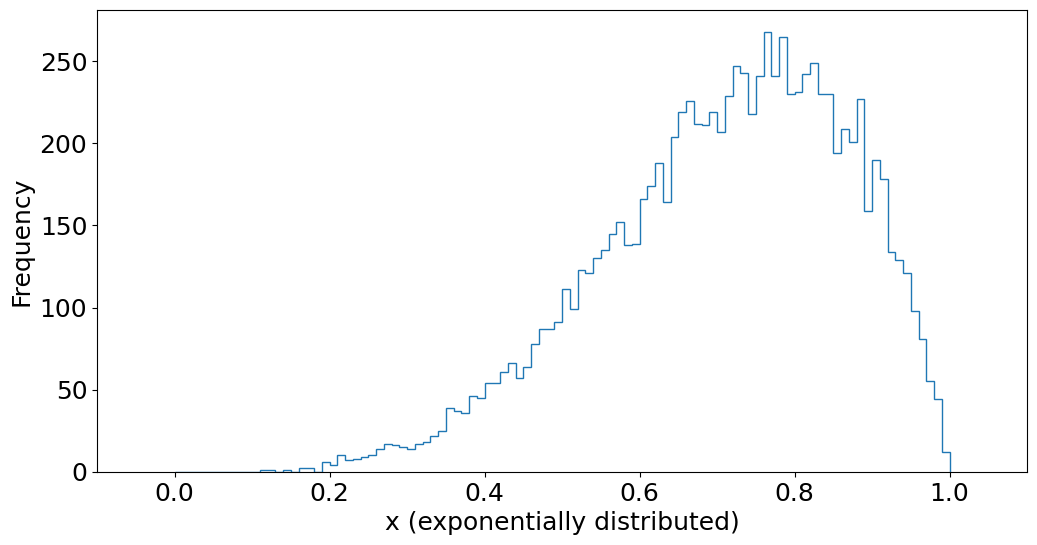

In [75]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin-0.1, xmax+0.1));

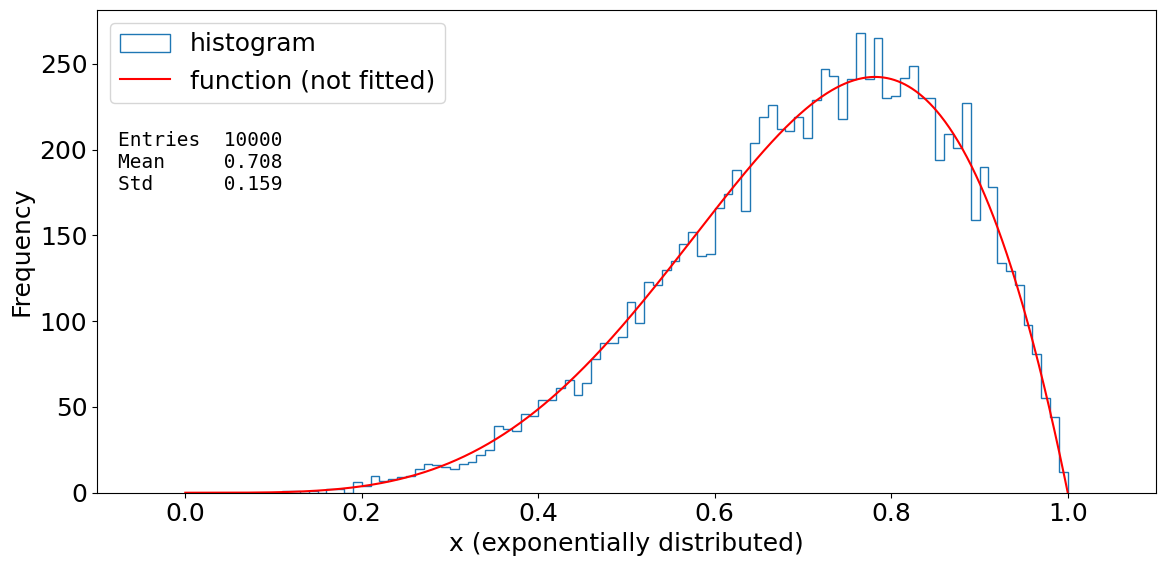

In [76]:
# Plot f(x)
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = fx_2x(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

# Define the figure text
d2 = {'Entries': len(x_accepted),
      'Mean': x_accepted.mean(),
      'Std': x_accepted.std(ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.75, text2, ax2, fontsize=14)

# Add legend
ax2.legend(loc='best')
fig2.tight_layout()

# Save figure
if save_plots: 
    fig2.savefig("Hist_2x_AcceptRejectMethod.pdf", dpi=600)
    
# Show the figure
fig2

In [77]:
def f_fit(x,a):
    return N_points/N_bins*8.0125*x**a*np.sin(np.pi*x)

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_accepted, bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

chi2fit = Chi2Regression(f_fit, x, y, sy)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2fit,a=1)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.05                      │              Nfcn = 33               │
│ EDM = 4.66e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   3.021   │   0.022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000487 │
└───┴──────────┘

In [78]:
def chi2_owncalc(x,a):
	y_fit = f_fit(x,a)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,3), stats.chi2.sf(chi2_owncalc(x,3), 85))

In [79]:
#Calculate degrees of freedom
print(len(y[y>0])-1)

85


In [80]:
print(chi2_owncalc(x,3), stats.chi2.sf(chi2_owncalc(x,3), 85))

64.95516105014211 0.9480173429231933


# Problem 4.1

In [81]:
def read_grip(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["Dominant hand", "Dominant grip", "Non Dominant grip"]) 
	return dat

grip_strength = read_grip("data_GripStrength.txt")
Dom_hand = grip_strength["Dominant hand"]
Dom_grip = grip_strength["Dominant grip"]
Non_Dom_grip = grip_strength["Non Dominant grip"]

In [82]:
count = 0 
for i in Dom_hand:
	if i == 1:
		count +=1

print(f'The amount of people that are right handed are {np.round(count/len(Dom_hand), 2)}')
print(f'The mean of the Dominant grip is {np.mean(Dom_grip)} with a standard deviation of {np.std(Dom_grip)}')
print(f'The mean of the Dominant grip is {np.mean(Non_Dom_grip)} with a standard deviation of {np.std(Non_Dom_grip)}')
print(f'The mean of the Dominant grip is {np.mean(Dom_grip-Non_Dom_grip)} with a standard deviation of {np.std(Dom_grip-Non_Dom_grip)}')


The amount of people that are right handed are 0.81
The mean of the Dominant grip is 444.93095238095236 with a standard deviation of 144.14294632510968
The mean of the Dominant grip is 418.48178571428565 with a standard deviation of 137.3924578851255
The mean of the Dominant grip is 26.449166666666674 with a standard deviation of 29.034518053366583


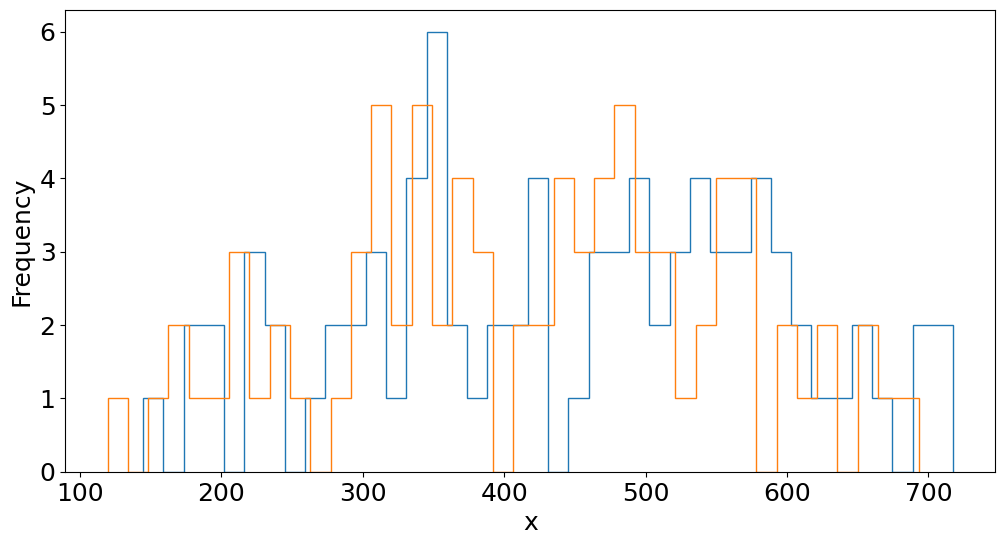

In [83]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(Dom_grip, bins=40, histtype='step', label='histogram' )
ax.set(xlabel="x", ylabel="Frequency");
ax.hist(Non_Dom_grip, bins=40, histtype='step', label='histogram' )


plt.show()


# Problem 4.2

In [86]:
def read_molecule(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["size", "intensity"]) 
	return dat

Molecule = read_molecule("data_MoleculeTypes.txt")
size = Molecule["size"]
intensity = Molecule["intensity"]

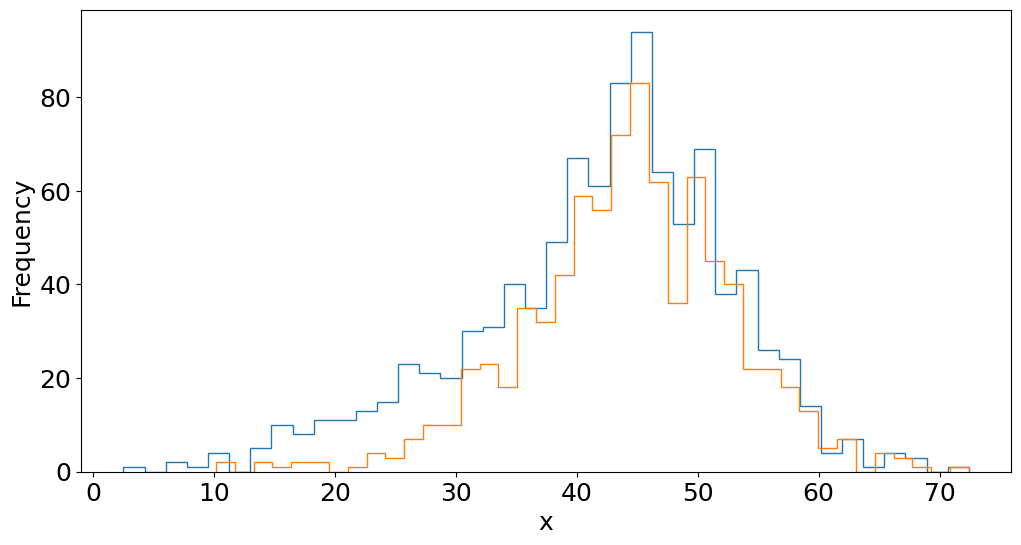

In [87]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size, bins=40, histtype='step', label='histogram')
ax.hist(size[np.flatnonzero(intensity>0.5)], bins=40, histtype='step', label='histogram')
ax.set(xlabel="x", ylabel="Frequency");

In [97]:
def gauss_fit(x,sigma, mu, N):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(size, bins=40)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m,sigma=20, mu=45, N=100)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()
print(*m.values)

9.310291854297557 42.62095358783883 1542.1065534302668


In [98]:
def chi2_owncalc(x,mu, sigma, N):
	y_fit = gauss_fit(x,mu, sigma, N)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,*m.values), stats.chi2.sf(chi2_owncalc(x,*m.values), 33))

105.86952288030615 1.4439414865771582e-09


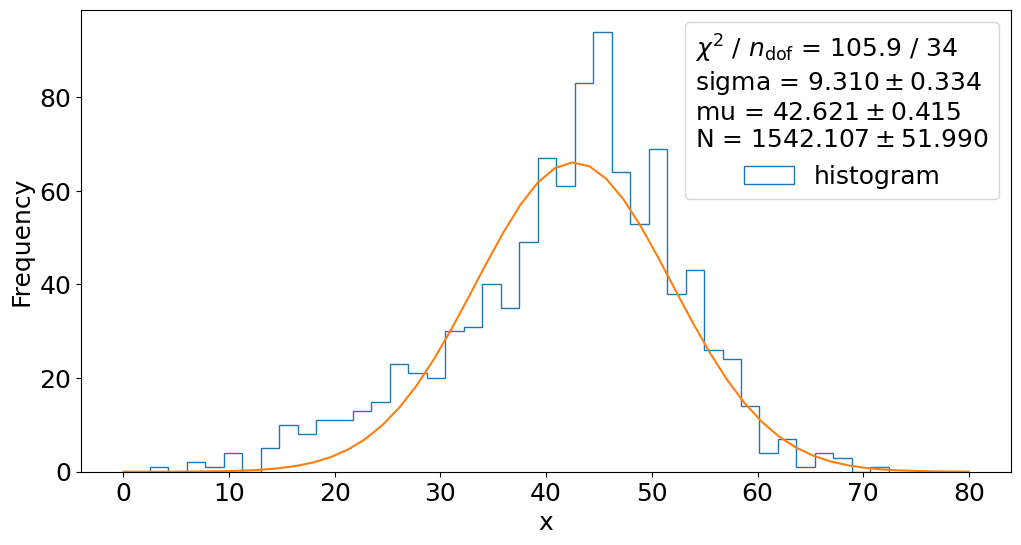

In [99]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size, bins=40, histtype='step', label='histogram')
ax.plot(np.linspace(0,80), gauss_fit(np.linspace(0,80),*m.values))
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


In [90]:
def gauss_fit(x,sigma, mu, N):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(size[np.flatnonzero(intensity>0.5)], bins=40)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m,sigma=20, mu=45, N=100)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 48.87 (chi2/ndof = 1.5)    │              Nfcn = 107              │
│ EDM = 6.61e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sigma │   8.21    │   0.26    │            │            │         │         │       │
│ 1 │ mu    │   44.59   │   0.30    │            │            │         │         │       │
│ 2 │ N     │  1.22e3   │  0.04e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │    sigma       mu        N │
├───────┼────────────────────────────┤
│ sigma │   0.0691 -0.00275    0.402 │
│    mu │ -0.00275   0.0901    0.138 │
│     N │    0.402    0.138 1.92e+03 │
└───────┴────────────────────────────┘

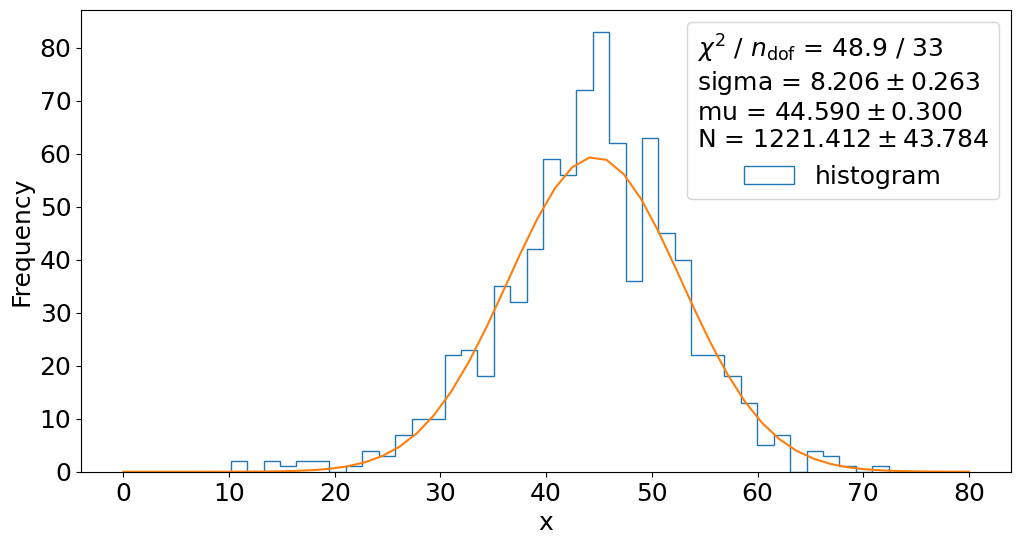

In [95]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size[np.flatnonzero(intensity>0.5)], bins=40, histtype='step', label='histogram')
ax.plot(np.linspace(0,80), gauss_fit(np.linspace(0,80), *m.values))
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));

In [96]:
def chi2_owncalc(x,mu, sigma, N):
	y_fit = gauss_fit(x,mu, sigma, N)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,*m.values), stats.chi2.sf(chi2_owncalc(x,*m.values), 33))

48.87097737633424 0.037052535596955316


In [106]:
def gauss_fit_double(x,sigma1,sigma2, mu1,mu2, N):
    return  N*(np.exp(-(x-mu1)**2/(2*sigma1**2)))/ (sigma1*np.sqrt(2*np.pi)) + N*(np.exp(-(x-mu2)**2/(2*sigma2**2)))/ (sigma2*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(size, bins=40)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit_double)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m,sigma1=20,sigma2=20, mu1=45,mu2 = 45, N=100)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 107 (chi2/ndof = 3.3)      │              Nfcn = 241              │
│ EDM = 4.27e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sigma1 │   9.36    │   0.33    │            │            │         │         │       │
│ 1 │ sigma2 │ -6.6433e3 │ 0.0020e3  │            │            │         │         │       │
│ 2 │ mu1    │   42.6    │    0.4    │            │            │         │         │       │
│ 3 │ mu2    │   36.8    │    2.0    │            │            │         │         │       │
│ 4 │ N      │ 1.5463e3  │ 0.0020e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────┐
│        │    sigma1    sigma2       mu1       mu2         N │
├────────┼───────────────────────────────────────────────────┤
│ sigma1 │     0.108  2.83e-05   -0.0844  1.54e-08  0.000442 │
│ sigma2 │  2.83e-05         4 -1.39e-05  4.25e-09  3.59e-06 │
│    mu1 │   -0.0844 -1.39e-05     0.164   6.3e-08 -0.000245 │
│    mu2 │  1.54e-08  4.25e-09   6.3e-08         4  1.14e-08 │
│      N │  0.000442  3.59e-06 -0.000245  1.14e-08      3.99 │
└────────┴───────────────────────────────────────────────────┘

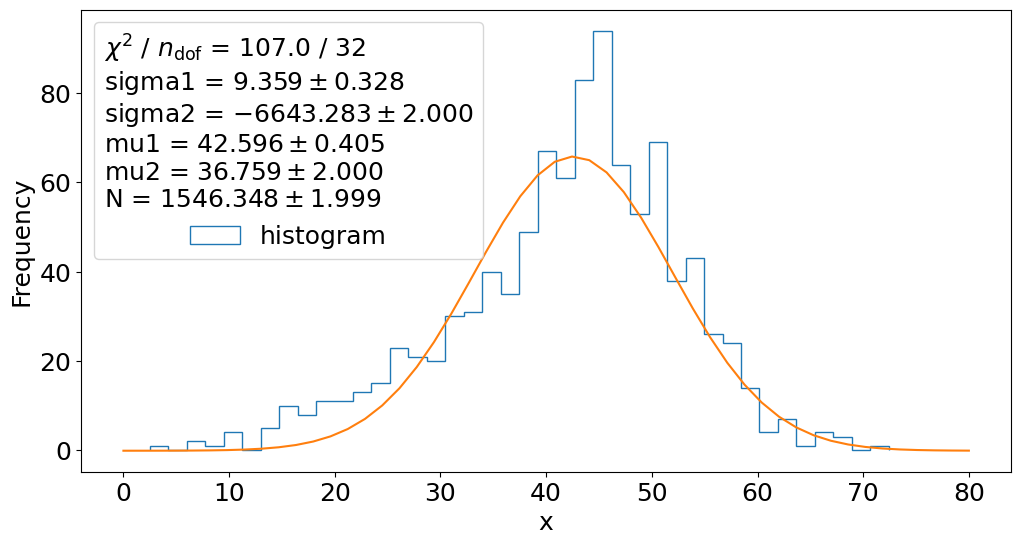

In [107]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size, bins=40, histtype='step', label='histogram')
ax.plot(np.linspace(0,80), gauss_fit_double(np.linspace(0,80), *m.values))
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));

# Problem 5.1

In [20]:
def read_algae(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["time", "area", "area_err"]) 
	return dat

algae = read_algae("data_AlgaeGrowth.txt")
time = algae["time"]
area = algae["area"]
area_err = algae["area_err"]

Text(0, 0.5, 'Area')

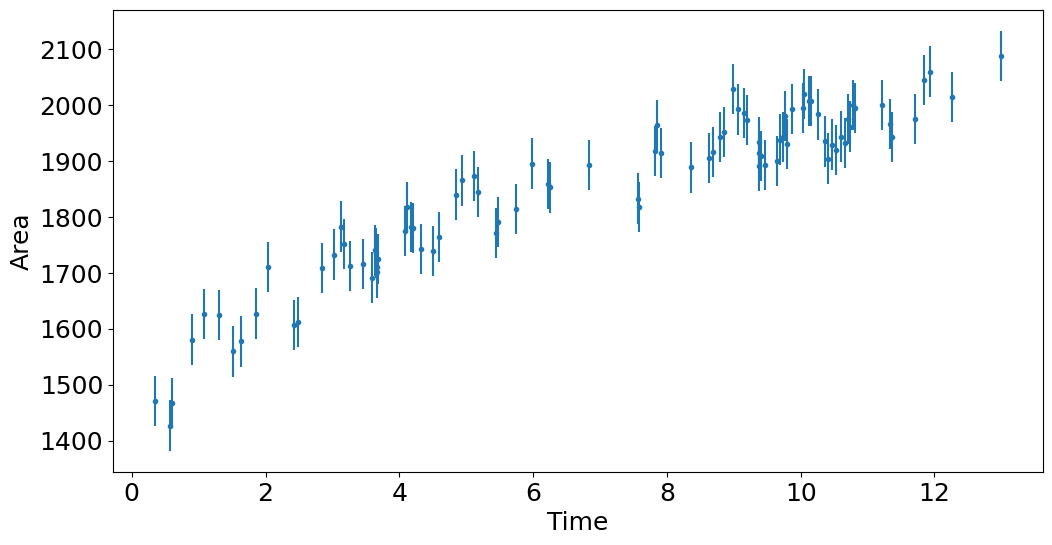

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(time, area, area_err, fmt = '.')
ax.set_xlabel('Time')
ax.set_ylabel('Area')


In [24]:
def third_fit(x,a,b,c,d,N):
    return  N*(a*x**3+b*x**2+c*x+d)

m = LeastSquares(time, area, area_err, third_fit)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m, a = 0, b = 0, c = 100, d=1000, N = 30)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 71.64 (chi2/ndof = 0.8)    │              Nfcn = 323              │
│ EDM = 8.13e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -1.71   │   0.18    │            │            │         │         │       │
│ 1 │ b    │   44.9    │    2.9    │            │            │         │         │       │
│ 2 │ c    │   -494    │    22     │            │            │         │         │       │
│ 3 │ d    │  -5.92e3  │  0.19e3   │            │            │         │         │       │
│ 4 │ N    │  -0.242   │   0.007   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────────────────────────────┐
│   │        a        b        c        d        N │
├───┼──────────────────────────────────────────────┤
│ a │   0.0314   -0.439     1.01    -1.63 9.73e-05 │
│ b │   -0.439     8.45    -44.3     42.6 0.000267 │
│ c │     1.01    -44.3      485      369  -0.0521 │
│ d │    -1.63     42.6      369 3.48e+04    -1.23 │
│ N │ 9.73e-05 0.000267  -0.0521    -1.23 4.83e-05 │
└───┴──────────────────────────────────────────────┘

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


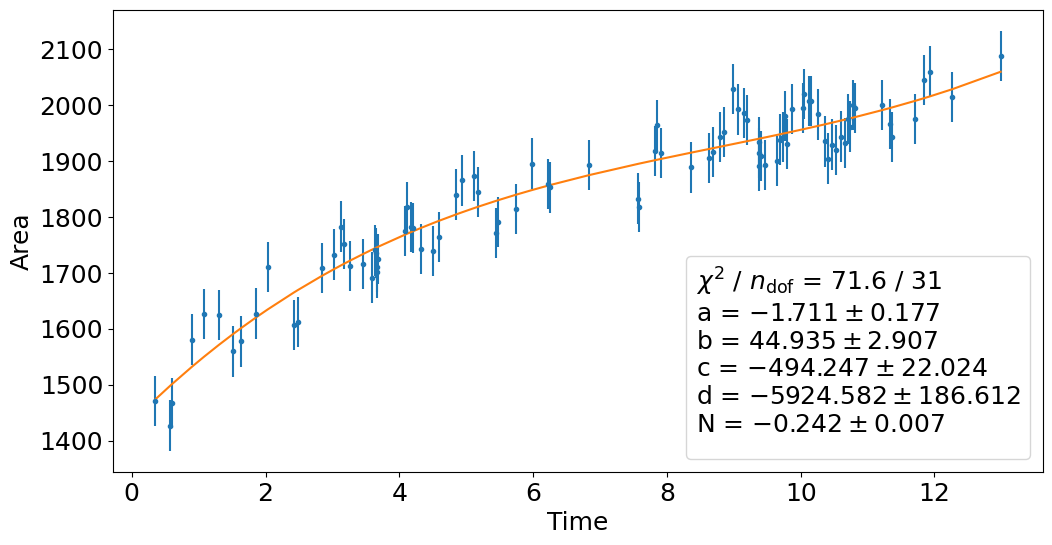

In [25]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

	
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(time, area, area_err, fmt = '.')
ax.plot(time, third_fit(time, *m.values))
ax.set_xlabel('Time')
ax.set_ylabel('Area')
ax.legend(title="\n".join(fit_info));

No this is a very bad fit

Text(0, 0.5, 'Area')

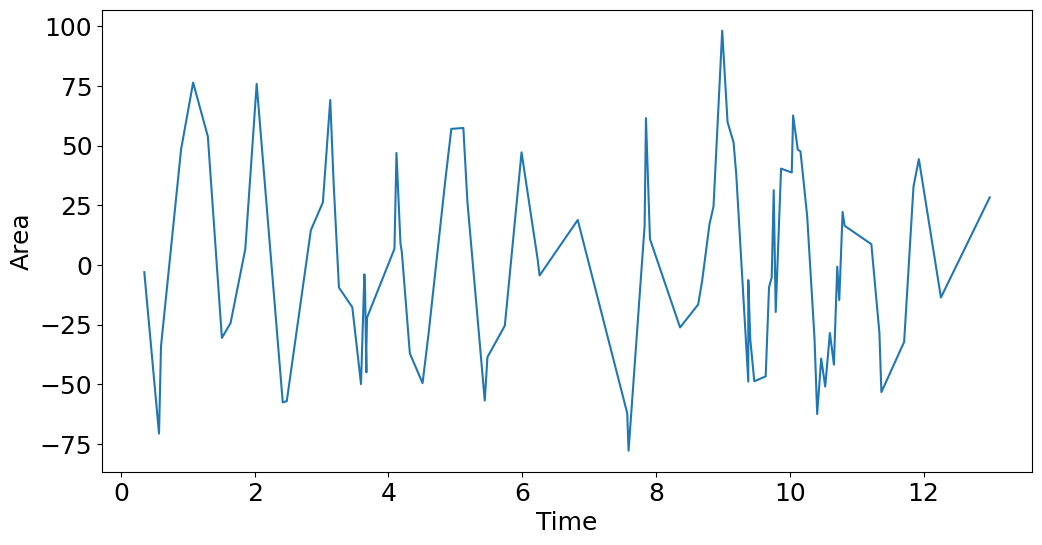

In [26]:
res = area - third_fit(time, *m.values)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, res)
ax.set_xlabel('Time')
ax.set_ylabel('Area')

# below is the runs test

In [27]:
def ww_runs(pos,neg,tot):

	mu = 2*pos*neg/tot + 1

	var = 2*pos*neg*(2*pos*neg-tot)/(tot**2*(tot-1))

	return mu, np.sqrt(var)


Npos = []
Nneg = []

for i in res:
	if i > 0:
		Npos.append(i)
	else:
		Nneg.append(i)

Npos = np.array(Npos)
Nneg = np.array(Nneg)
Ntot = len(Npos) + len(Nneg)

print(len(res))
ww_runs(len(Npos),len(Nneg),Ntot)

90


(45.8, 4.695491502434884)

In [68]:
def third_fit_mod(x,a,b,c,d,e,N):
    return  N*(a*x**3+b*x**2+c*x+d) + N*np.sin(e*x)

m = LeastSquares(time, area, area_err, third_fit_mod)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m, a = 0, b = 0, c = 100, d=1000, e=0, N = 30)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 71.5 (chi2/ndof = 0.9)     │             Nfcn = 1044              │
│ EDM = 0.000522 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -1.5    │    0.6    │            │            │         │         │       │
│ 1 │ b    │    39     │    13     │            │            │         │         │       │
│ 2 │ c    │  -0.43e3  │  0.11e3   │            │            │         │         │       │
│ 3 │ d    │  -5.1e3   │   1.2e3   │            │            │         │         │       │
│ 4 │ e    │  -339.0   │    0.5    │            │            │         │         │       │
│ 5 │ N    │   -0.28   │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────────────────────┐
│   │         a         b         c         d         e         N │
├───┼─────────────────────────────────────────────────────────────┤
│ a │     0.332      -7.2      55.7       374   0.00783   -0.0217 │
│ b │      -7.2       163 -1.35e+03 -9.92e+03    -0.145      0.57 │
│ c │      55.7 -1.35e+03  1.25e+04  1.12e+05     0.689     -6.27 │
│ d │       374 -9.92e+03  1.12e+05   1.4e+06     -1.08     -75.3 │
│ e │   0.00783    -0.145     0.689     -1.08     0.292  2.34e-05 │
│ N │   -0.0217      0.57     -6.27     -75.3  2.34e-05   0.00407 │
└───┴─────────────────────────────────────────────────────────────┘

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


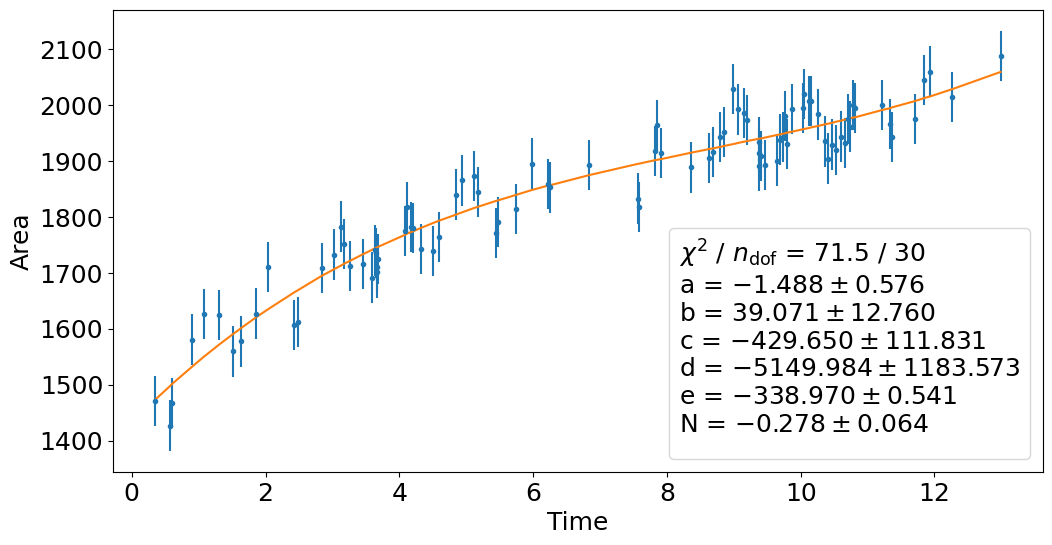

In [69]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

	
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(time, area, area_err, fmt = '.')
ax.plot(time, third_fit_mod(time, *m.values))
ax.set_xlabel('Time')
ax.set_ylabel('Area')
ax.legend(title="\n".join(fit_info));